# Time Series Analysis of Wildfire-Induced Power Outages

This notebook analyzes temporal patterns in power outages and wildfire activity.

## Objectives
1. Analyze **seasonal patterns** in outages and wildfire activity
2. Perform **trend analysis** over the study period (2000-2016)
3. Apply **time series decomposition** (trend, seasonality, residuals)
4. Explore **lag relationships** between wildfire activity and outages
5. Build **forecasting models** (ARIMA, Exponential Smoothing)

## Research Question Addressed
> How do seasonal and climatic factors influence the wildfire-outage relationship?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Time series specific imports
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
pd.set_option('display.max_columns', 50)

# Path configuration
FEATURES_PATH = '../data/features/'
OUTPUTS_PATH = '../outputs/'

In [2]:
# Load datasets
outages = pd.read_csv(FEATURES_PATH + 'california_outages_with_fire_features.csv')
daily_fires = pd.read_csv(FEATURES_PATH + 'daily_wildfire_aggregations.csv')
monthly_fires = pd.read_csv(FEATURES_PATH + 'monthly_wildfire_aggregations.csv')

# Convert date columns
outages['outage_date'] = pd.to_datetime(outages['outage_date'])
daily_fires['fire_date'] = pd.to_datetime(daily_fires['fire_date'])
monthly_fires['year_month'] = pd.to_datetime(monthly_fires['year_month'])

print(f"Outages: {outages.shape[0]} records ({outages['outage_date'].min().date()} to {outages['outage_date'].max().date()})")
print(f"Daily fires: {daily_fires.shape[0]} days")
print(f"Monthly fires: {monthly_fires.shape[0]} months")

Outages: 210 records (2000-06-14 to 2016-04-02)
Daily fires: 8766 days
Monthly fires: 288 months


---
## Create Time Series Data

Aggregate outage data by month for time series analysis.

In [3]:
# Create monthly outage counts
outages['year_month'] = outages['outage_date'].dt.to_period('M').dt.to_timestamp()

monthly_outages = outages.groupby('year_month').agg({
    'outage_date': 'count',
    'OUTAGE.DURATION': 'mean',
    'CUSTOMERS.AFFECTED': 'mean',
    'DEMAND.LOSS.MW': 'mean',
    'is_high_severity': 'sum',
    'is_wildfire_related': 'sum'
}).rename(columns={'outage_date': 'outage_count'})

# Create complete monthly date range
date_range = pd.date_range(
    start=monthly_outages.index.min(),
    end=monthly_outages.index.max(),
    freq='MS'
)

# Reindex to include months with zero outages
monthly_outages = monthly_outages.reindex(date_range, fill_value=0)
monthly_outages.index.name = 'year_month'

print(f"Monthly outage series: {len(monthly_outages)} months")
print(f"\nMonthly outage statistics:")
print(monthly_outages['outage_count'].describe())

Monthly outage series: 191 months

Monthly outage statistics:
count    191.000000
mean       1.099476
std        1.339894
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        6.000000
Name: outage_count, dtype: float64


In [4]:
# Merge with monthly fire data
monthly_fires_indexed = monthly_fires.set_index('year_month')
monthly_combined = monthly_outages.join(monthly_fires_indexed, how='left')
monthly_combined = monthly_combined.fillna(0)

print(f"Combined monthly dataset: {monthly_combined.shape}")
print(f"\nColumns: {monthly_combined.columns.tolist()}")
monthly_combined.head(10)

Combined monthly dataset: (191, 11)

Columns: ['outage_count', 'OUTAGE.DURATION', 'CUSTOMERS.AFFECTED', 'DEMAND.LOSS.MW', 'is_high_severity', 'is_wildfire_related', 'monthly_fire_count', 'monthly_acres_burned', 'avg_fire_size', 'max_fire_size', 'most_common_cause']


,outage_count,OUTAGE.DURATION,CUSTOMERS.AFFECTED,DEMAND.LOSS.MW,is_high_severity,is_wildfire_related,monthly_fire_count,monthly_acres_burned,avg_fire_size,max_fire_size,most_common_cause
year_month,,,,,,,,,,,
2000-06-01,1,0.0,32000.0,130.0,0,0,1185.0,16014.0,13.513924,5731.0,Equipment Use
2000-07-01,0,0.0,0.0,0.0,0,0,1496.0,121903.2,81.486096,75000.0,Miscellaneous
2000-08-01,0,0.0,0.0,0.0,0,0,1492.0,80738.9,54.114544,55261.0,Lightning
2000-09-01,0,0.0,0.0,0.0,0,0,758.0,16120.6,21.267282,8284.0,Equipment Use
2000-10-01,0,0.0,0.0,0.0,0,0,493.0,8640.2,17.525761,4500.0,Equipment Use
2000-11-01,0,0.0,0.0,0.0,0,0,198.0,184.2,0.930303,30.0,Miscellaneous
2000-12-01,0,0.0,0.0,0.0,0,0,162.0,1247.2,7.698765,480.0,Miscellaneous
2001-01-01,2,1945.0,0.0,400.0,0,0,156.0,10890.9,69.813462,10353.0,Miscellaneous
2001-02-01,0,0.0,0.0,0.0,0,0,61.0,2562.8,42.013115,2400.0,Miscellaneous


---
## Part 1: Seasonal Pattern Analysis

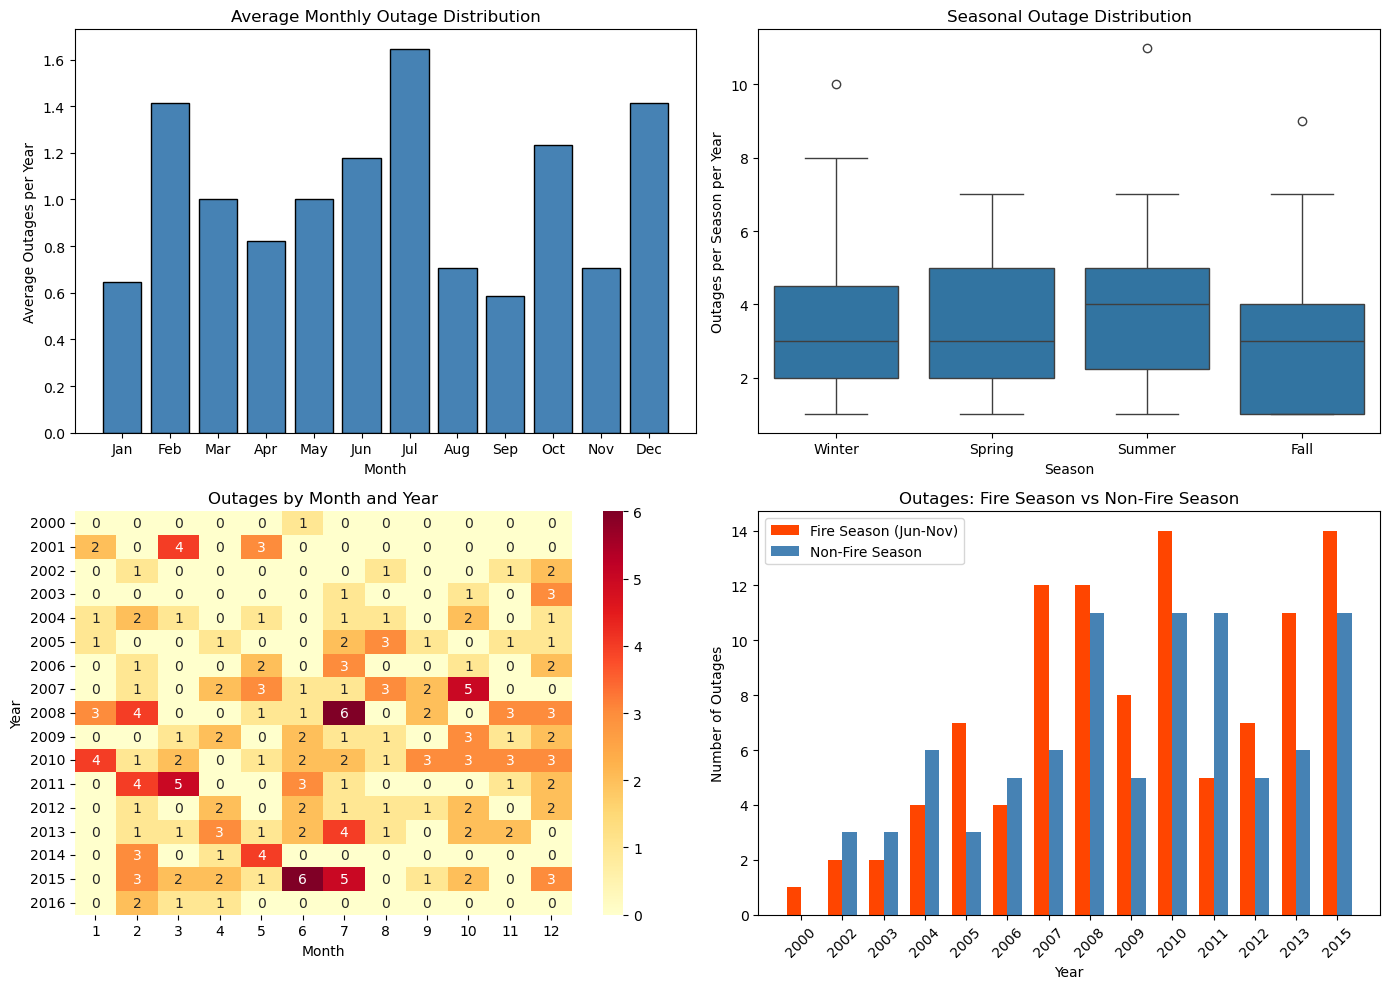

In [5]:
# Analyze seasonal patterns in outages
outages['month'] = outages['outage_date'].dt.month
outages['year'] = outages['outage_date'].dt.year

# Monthly average outages
monthly_avg = outages.groupby('month').size() / outages['year'].nunique()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Monthly distribution
axes[0, 0].bar(monthly_avg.index, monthly_avg.values, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Average Outages per Year')
axes[0, 0].set_title('Average Monthly Outage Distribution')
axes[0, 0].set_xticks(range(1, 13))
axes[0, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Seasonal boxplot
seasonal_order = ['Winter', 'Spring', 'Summer', 'Fall']
season_map = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring',
              6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 
              11: 'Fall', 12: 'Winter'}
outages['season_mapped'] = outages['month'].map(season_map)

season_counts = outages.groupby(['year', 'season_mapped']).size().reset_index(name='count')
sns.boxplot(x='season_mapped', y='count', data=season_counts, order=seasonal_order, ax=axes[0, 1])
axes[0, 1].set_xlabel('Season')
axes[0, 1].set_ylabel('Outages per Season per Year')
axes[0, 1].set_title('Seasonal Outage Distribution')

# Monthly heatmap by year
monthly_pivot = outages.groupby(['year', 'month']).size().unstack(fill_value=0)
sns.heatmap(monthly_pivot, cmap='YlOrRd', annot=True, fmt='d', ax=axes[1, 0])
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Year')
axes[1, 0].set_title('Outages by Month and Year')

# Fire season vs non-fire season
fire_season = outages[outages['is_wildfire_season'] == 1].groupby('year').size()
non_fire_season = outages[outages['is_wildfire_season'] == 0].groupby('year').size()

x = np.arange(len(fire_season.index))
width = 0.35
axes[1, 1].bar(x - width/2, fire_season.values, width, label='Fire Season (Jun-Nov)', color='orangered')
axes[1, 1].bar(x + width/2, non_fire_season.reindex(fire_season.index).fillna(0).values, 
               width, label='Non-Fire Season', color='steelblue')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Number of Outages')
axes[1, 1].set_title('Outages: Fire Season vs Non-Fire Season')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(fire_season.index, rotation=45)
axes[1, 1].legend()

plt.tight_layout()
plt.savefig(OUTPUTS_PATH + 'figures/seasonal_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

Correlation between monthly outages and fire activity:
                      outage_count  monthly_fire_count  monthly_acres_burned
outage_count              1.000000            0.042893              0.111307
monthly_fire_count        0.042893            1.000000              0.487314
monthly_acres_burned      0.111307            0.487314              1.000000


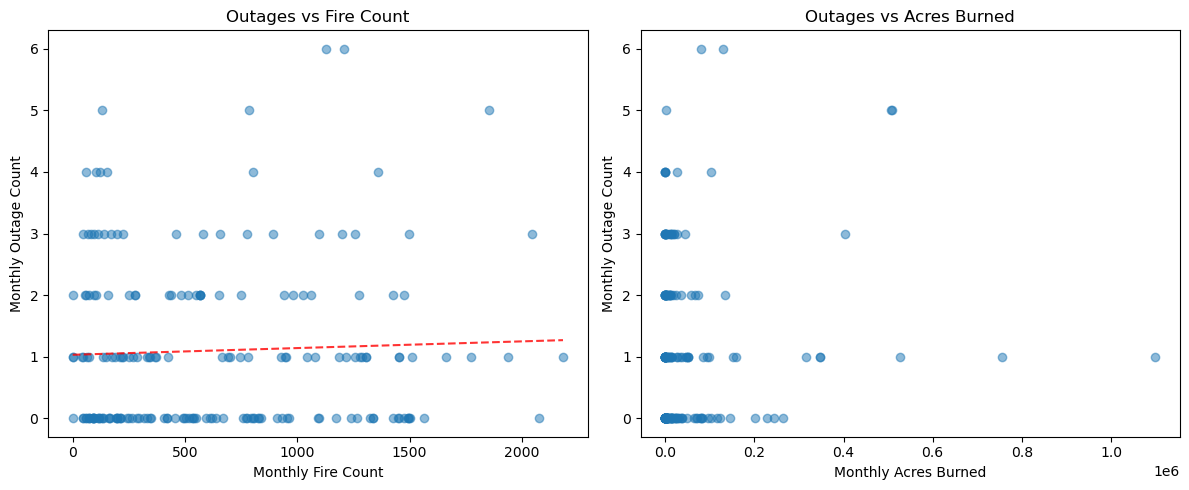

In [6]:
# Correlation between monthly outages and fire activity
if 'monthly_fire_count' in monthly_combined.columns:
    correlation_cols = ['outage_count', 'monthly_fire_count', 'monthly_acres_burned']
    correlation_cols = [col for col in correlation_cols if col in monthly_combined.columns]
    
    print("Correlation between monthly outages and fire activity:")
    print(monthly_combined[correlation_cols].corr())
    
    # Scatter plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    if 'monthly_fire_count' in monthly_combined.columns:
        axes[0].scatter(monthly_combined['monthly_fire_count'], monthly_combined['outage_count'], alpha=0.5)
        axes[0].set_xlabel('Monthly Fire Count')
        axes[0].set_ylabel('Monthly Outage Count')
        axes[0].set_title('Outages vs Fire Count')
        
        # Add trend line
        z = np.polyfit(monthly_combined['monthly_fire_count'].fillna(0), 
                       monthly_combined['outage_count'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(0, monthly_combined['monthly_fire_count'].max(), 100)
        axes[0].plot(x_line, p(x_line), 'r--', alpha=0.8)
    
    if 'monthly_acres_burned' in monthly_combined.columns:
        axes[1].scatter(monthly_combined['monthly_acres_burned'], monthly_combined['outage_count'], alpha=0.5)
        axes[1].set_xlabel('Monthly Acres Burned')
        axes[1].set_ylabel('Monthly Outage Count')
        axes[1].set_title('Outages vs Acres Burned')
    
    plt.tight_layout()
    plt.savefig(OUTPUTS_PATH + 'figures/outage_fire_correlation.png', dpi=150, bbox_inches='tight')
    plt.show()

---
## Part 2: Trend Analysis

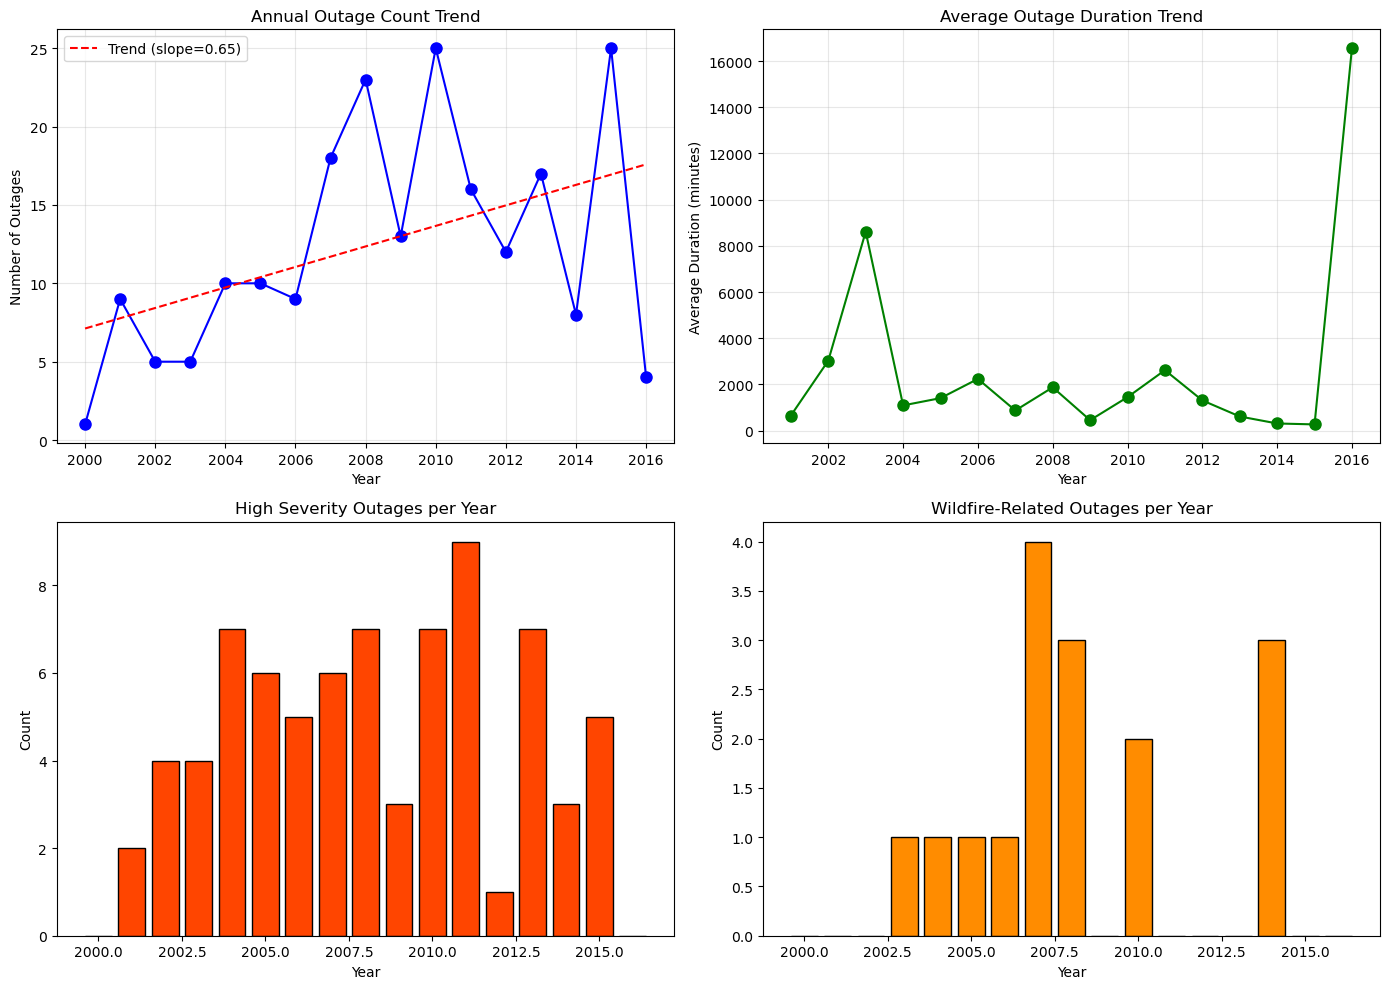


Trend Analysis Results:
  Correlation (year vs outage count): 0.451
  P-value: 0.0694
  Trend: Increasing (Not Significant)


In [7]:
# Annual trend analysis
yearly_outages = outages.groupby('year').agg({
    'outage_date': 'count',
    'OUTAGE.DURATION': 'mean',
    'is_high_severity': 'sum',
    'is_wildfire_related': 'sum'
}).rename(columns={'outage_date': 'count'})

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Outage count trend
axes[0, 0].plot(yearly_outages.index, yearly_outages['count'], 'bo-', markersize=8)
z = np.polyfit(yearly_outages.index, yearly_outages['count'], 1)
p = np.poly1d(z)
axes[0, 0].plot(yearly_outages.index, p(yearly_outages.index), 'r--', label=f'Trend (slope={z[0]:.2f})')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Number of Outages')
axes[0, 0].set_title('Annual Outage Count Trend')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Average duration trend
axes[0, 1].plot(yearly_outages.index, yearly_outages['OUTAGE.DURATION'], 'go-', markersize=8)
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Average Duration (minutes)')
axes[0, 1].set_title('Average Outage Duration Trend')
axes[0, 1].grid(True, alpha=0.3)

# High severity outages trend
axes[1, 0].bar(yearly_outages.index, yearly_outages['is_high_severity'], color='orangered', edgecolor='black')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('High Severity Outages per Year')

# Wildfire-related outages trend
axes[1, 1].bar(yearly_outages.index, yearly_outages['is_wildfire_related'], color='darkorange', edgecolor='black')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Wildfire-Related Outages per Year')

plt.tight_layout()
plt.savefig(OUTPUTS_PATH + 'figures/trend_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistical trend test (Mann-Kendall would be ideal, using simple correlation here)
correlation, p_value = stats.pearsonr(yearly_outages.index, yearly_outages['count'])
print(f"\nTrend Analysis Results:")
print(f"  Correlation (year vs outage count): {correlation:.3f}")
print(f"  P-value: {p_value:.4f}")
print(f"  Trend: {'Increasing' if correlation > 0 else 'Decreasing'} ({'Significant' if p_value < 0.05 else 'Not Significant'})")

---
## Part 3: Time Series Decomposition

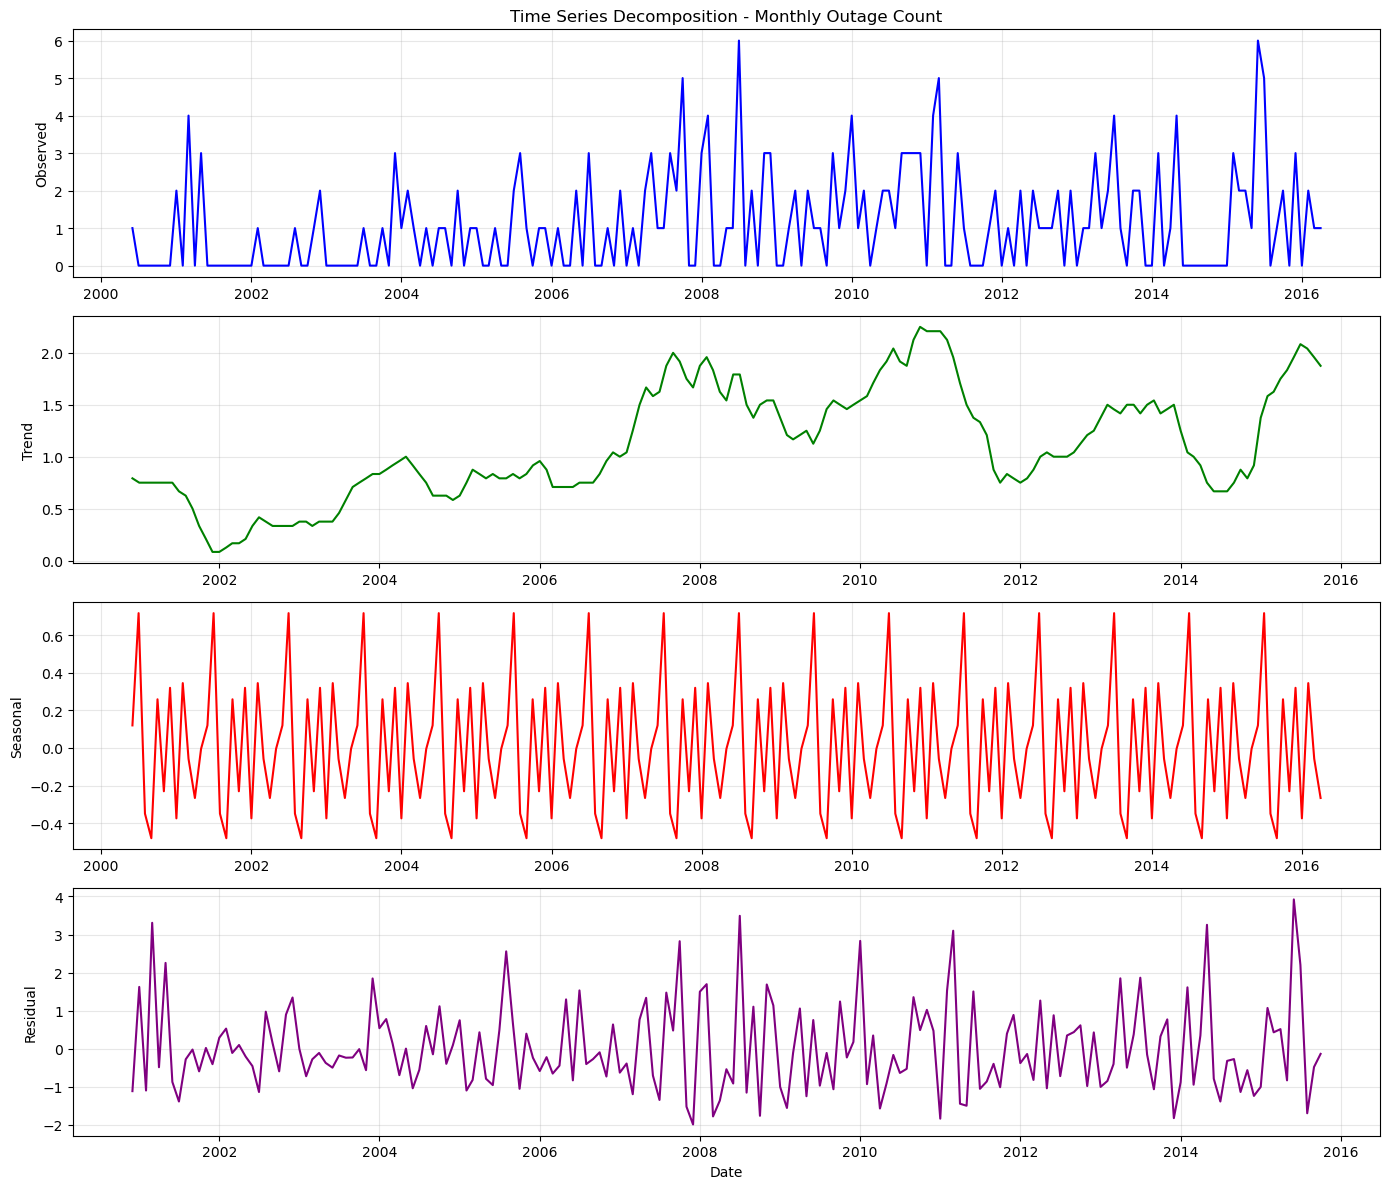


Seasonal Pattern (Monthly):
  Jan: +0.120
  Feb: +0.717
  Mar: -0.349
  Apr: -0.480
  May: +0.259
  Jun: -0.230
  Jul: +0.320
  Aug: -0.374
  Sep: +0.345
  Oct: -0.058
  Nov: -0.266
  Dec: -0.005


In [8]:
# Time series decomposition
# Use monthly outage count series
ts_data = monthly_combined['outage_count'].copy()

# Handle zeros for multiplicative decomposition (add small constant)
ts_data_adj = ts_data + 0.1

# Perform decomposition (additive model due to low counts)
try:
    decomposition = seasonal_decompose(ts_data, model='additive', period=12)
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    
    axes[0].plot(decomposition.observed, 'b-')
    axes[0].set_ylabel('Observed')
    axes[0].set_title('Time Series Decomposition - Monthly Outage Count')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(decomposition.trend, 'g-')
    axes[1].set_ylabel('Trend')
    axes[1].grid(True, alpha=0.3)
    
    axes[2].plot(decomposition.seasonal, 'r-')
    axes[2].set_ylabel('Seasonal')
    axes[2].grid(True, alpha=0.3)
    
    axes[3].plot(decomposition.resid, 'purple')
    axes[3].set_ylabel('Residual')
    axes[3].set_xlabel('Date')
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUTS_PATH + 'figures/timeseries_decomposition.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Extract seasonal pattern
    seasonal_pattern = decomposition.seasonal[:12]
    print("\nSeasonal Pattern (Monthly):")
    for i, val in enumerate(seasonal_pattern):
        month_name = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][i]
        print(f"  {month_name}: {val:+.3f}")
        
except Exception as e:
    print(f"Decomposition error: {e}")
    print("Insufficient data for seasonal decomposition.")

---
## Part 4: Stationarity Testing & ACF/PACF Analysis

In [9]:
# Augmented Dickey-Fuller test for stationarity
def adf_test(series, name):
    result = adfuller(series.dropna())
    print(f"\nADF Test for {name}:")
    print(f"  Test Statistic: {result[0]:.4f}")
    print(f"  P-Value: {result[1]:.4f}")
    print(f"  Critical Values:")
    for key, value in result[4].items():
        print(f"    {key}: {value:.4f}")
    print(f"  Conclusion: {'Stationary' if result[1] < 0.05 else 'Non-Stationary'}")
    return result[1] < 0.05

# Test original series
is_stationary = adf_test(ts_data, "Monthly Outage Count")

# If non-stationary, test differenced series
if not is_stationary:
    ts_diff = ts_data.diff().dropna()
    adf_test(ts_diff, "Differenced Monthly Outage Count")


ADF Test for Monthly Outage Count:
  Test Statistic: -2.9755
  P-Value: 0.0372
  Critical Values:
    1%: -3.4670
    5%: -2.8776
    10%: -2.5754
  Conclusion: Stationary


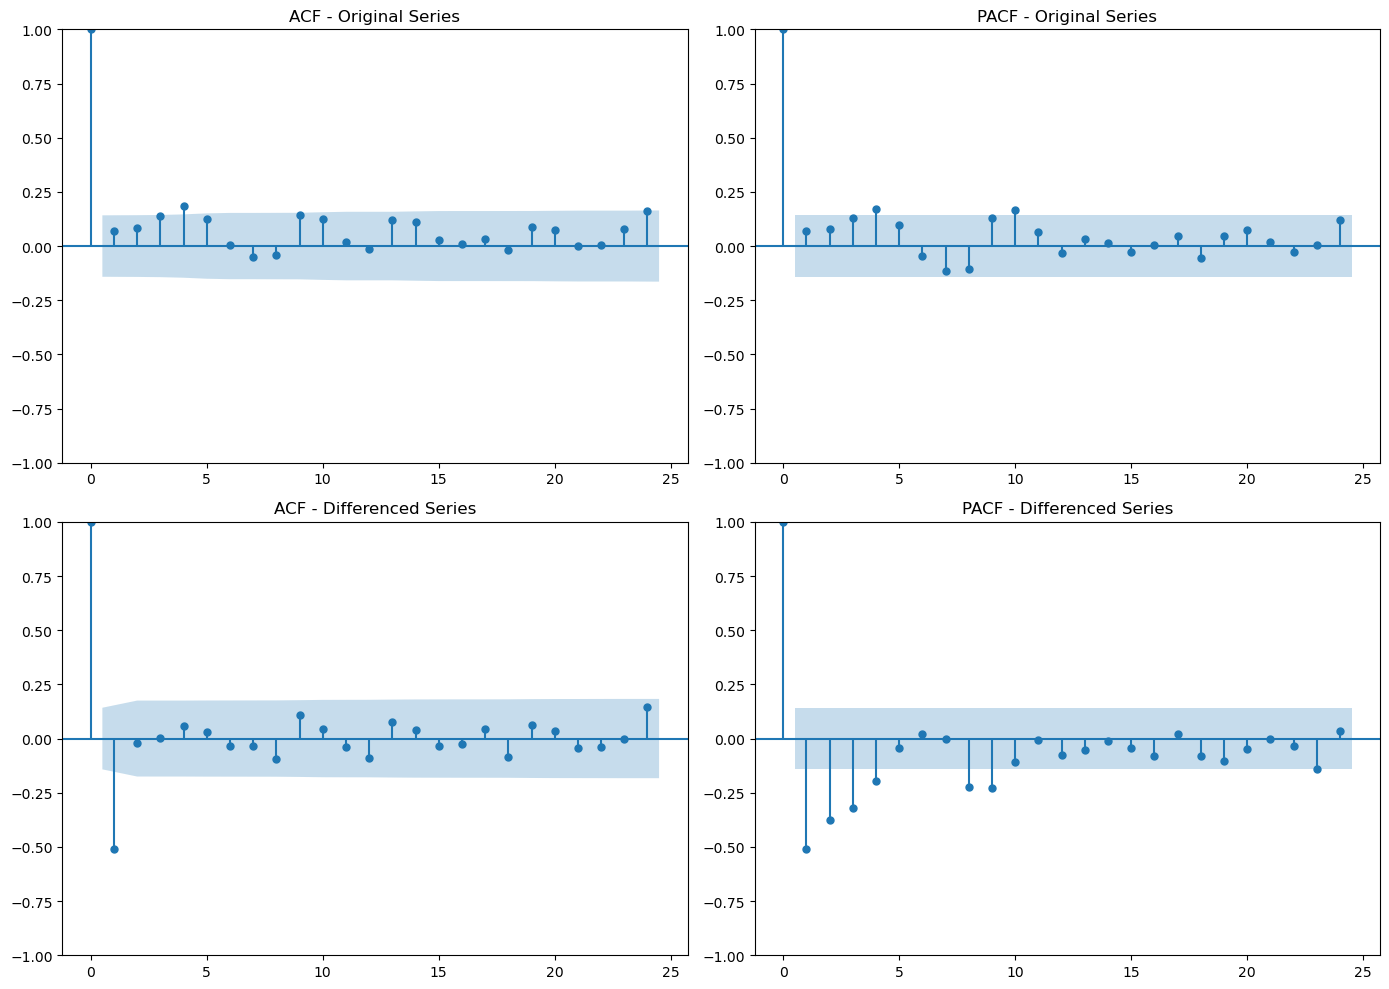


ACF/PACF Interpretation:
- Significant spikes at lag 12 indicate annual seasonality
- PACF helps determine AR order (p)
- ACF helps determine MA order (q)


In [10]:
# ACF and PACF plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Original series
plot_acf(ts_data.dropna(), lags=24, ax=axes[0, 0])
axes[0, 0].set_title('ACF - Original Series')

plot_pacf(ts_data.dropna(), lags=24, ax=axes[0, 1], method='ywm')
axes[0, 1].set_title('PACF - Original Series')

# Differenced series
ts_diff = ts_data.diff().dropna()
plot_acf(ts_diff, lags=24, ax=axes[1, 0])
axes[1, 0].set_title('ACF - Differenced Series')

plot_pacf(ts_diff, lags=24, ax=axes[1, 1], method='ywm')
axes[1, 1].set_title('PACF - Differenced Series')

plt.tight_layout()
plt.savefig(OUTPUTS_PATH + 'figures/acf_pacf.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nACF/PACF Interpretation:")
print("- Significant spikes at lag 12 indicate annual seasonality")
print("- PACF helps determine AR order (p)")
print("- ACF helps determine MA order (q)")

---
## Part 5: Lag Analysis (Cross-Correlation)

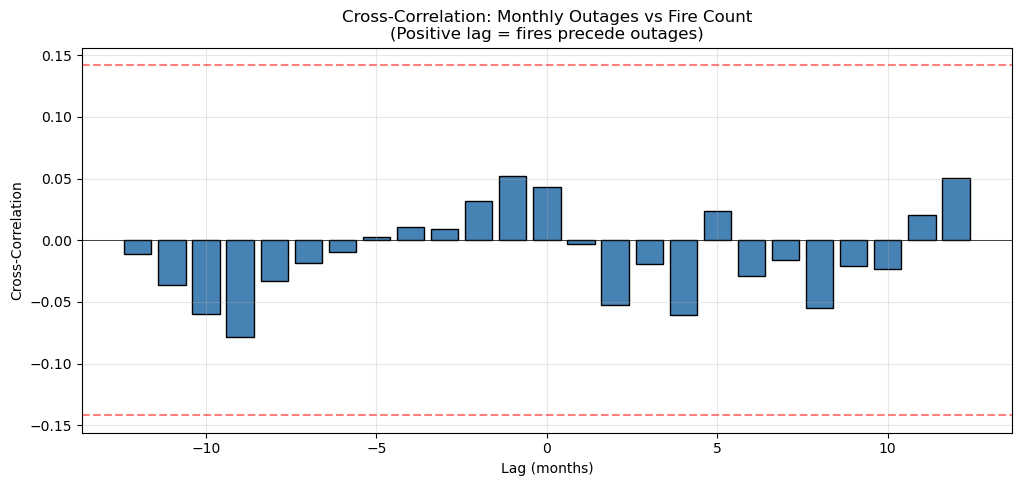


Optimal Lag: -9 months
Maximum Cross-Correlation: -0.078

Interpretation:
  Outages 9 month(s) BEFORE have strongest correlation with fires


In [11]:
# Cross-correlation between fire activity and outages
if 'monthly_fire_count' in monthly_combined.columns:
    from scipy.signal import correlate
    
    outage_series = monthly_combined['outage_count'].fillna(0).values
    fire_series = monthly_combined['monthly_fire_count'].fillna(0).values
    
    # Normalize
    outage_norm = (outage_series - outage_series.mean()) / outage_series.std()
    fire_norm = (fire_series - fire_series.mean()) / fire_series.std()
    
    # Cross-correlation
    max_lag = 12
    correlations = []
    for lag in range(-max_lag, max_lag + 1):
        if lag < 0:
            corr = np.corrcoef(outage_norm[:lag], fire_norm[-lag:])[0, 1]
        elif lag > 0:
            corr = np.corrcoef(outage_norm[lag:], fire_norm[:-lag])[0, 1]
        else:
            corr = np.corrcoef(outage_norm, fire_norm)[0, 1]
        correlations.append(corr)
    
    lags = range(-max_lag, max_lag + 1)
    
    plt.figure(figsize=(12, 5))
    plt.bar(lags, correlations, color='steelblue', edgecolor='black')
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    plt.axhline(y=1.96/np.sqrt(len(outage_series)), color='red', linestyle='--', alpha=0.5)
    plt.axhline(y=-1.96/np.sqrt(len(outage_series)), color='red', linestyle='--', alpha=0.5)
    plt.xlabel('Lag (months)')
    plt.ylabel('Cross-Correlation')
    plt.title('Cross-Correlation: Monthly Outages vs Fire Count\n(Positive lag = fires precede outages)')
    plt.grid(True, alpha=0.3)
    plt.savefig(OUTPUTS_PATH + 'figures/cross_correlation.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Find optimal lag
    optimal_lag = lags[np.argmax(np.abs(correlations))]
    max_corr = correlations[np.argmax(np.abs(correlations))]
    print(f"\nOptimal Lag: {optimal_lag} months")
    print(f"Maximum Cross-Correlation: {max_corr:.3f}")
    print(f"\nInterpretation:")
    if optimal_lag > 0:
        print(f"  Fire activity {optimal_lag} month(s) BEFORE has strongest correlation with outages")
    elif optimal_lag < 0:
        print(f"  Outages {-optimal_lag} month(s) BEFORE have strongest correlation with fires")
    else:
        print(f"  Concurrent fire activity has strongest correlation with outages")

---
## Part 6: Forecasting Models

In [12]:
# Split data for forecasting (80% train, 20% test)
train_size = int(len(ts_data) * 0.8)
train_data = ts_data[:train_size]
test_data = ts_data[train_size:]

print(f"Training period: {train_data.index[0]} to {train_data.index[-1]} ({len(train_data)} months)")
print(f"Test period: {test_data.index[0]} to {test_data.index[-1]} ({len(test_data)} months)")

Training period: 2000-06-01 00:00:00 to 2013-01-01 00:00:00 (152 months)
Test period: 2013-02-01 00:00:00 to 2016-04-01 00:00:00 (39 months)


In [13]:
# ARIMA Model
print("=" * 80)
print("ARIMA MODEL")
print("=" * 80)

# Try different ARIMA orders
best_aic = float('inf')
best_order = None
best_model = None

for p in range(3):
    for d in range(2):
        for q in range(3):
            try:
                model = ARIMA(train_data, order=(p, d, q))
                fitted = model.fit()
                if fitted.aic < best_aic:
                    best_aic = fitted.aic
                    best_order = (p, d, q)
                    best_model = fitted
            except:
                continue

print(f"Best ARIMA order: {best_order}")
print(f"Best AIC: {best_aic:.2f}")

# Forecast
if best_model is not None:
    arima_forecast = best_model.forecast(steps=len(test_data))
    
    # Evaluation metrics
    arima_mae = np.mean(np.abs(test_data.values - arima_forecast.values))
    arima_rmse = np.sqrt(np.mean((test_data.values - arima_forecast.values)**2))
    
    print(f"\nForecast Performance:")
    print(f"  MAE: {arima_mae:.3f}")
    print(f"  RMSE: {arima_rmse:.3f}")

ARIMA MODEL
Best ARIMA order: (0, 1, 1)
Best AIC: 498.92

Forecast Performance:
  MAE: 1.193
  RMSE: 1.544


In [14]:
# Exponential Smoothing (Holt-Winters)
print("\n" + "=" * 80)
print("EXPONENTIAL SMOOTHING (HOLT-WINTERS)")
print("=" * 80)

try:
    # Fit model with additive trend and seasonality
    hw_model = ExponentialSmoothing(
        train_data,
        trend='add',
        seasonal='add',
        seasonal_periods=12
    ).fit()
    
    hw_forecast = hw_model.forecast(steps=len(test_data))
    
    # Evaluation metrics
    hw_mae = np.mean(np.abs(test_data.values - hw_forecast.values))
    hw_rmse = np.sqrt(np.mean((test_data.values - hw_forecast.values)**2))
    
    print(f"Forecast Performance:")
    print(f"  MAE: {hw_mae:.3f}")
    print(f"  RMSE: {hw_rmse:.3f}")
    
except Exception as e:
    print(f"Exponential Smoothing error: {e}")
    hw_forecast = None


EXPONENTIAL SMOOTHING (HOLT-WINTERS)
Forecast Performance:
  MAE: 1.291
  RMSE: 1.555


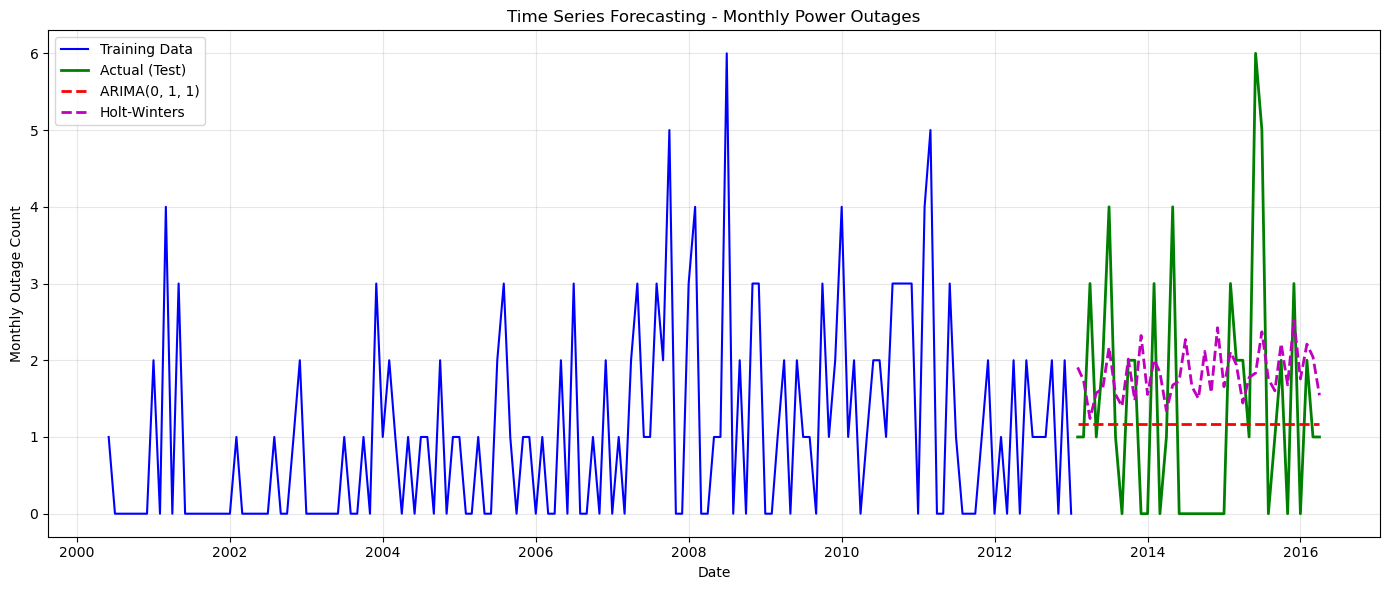


FORECASTING MODEL COMPARISON
         Model      MAE     RMSE
ARIMA(0, 1, 1) 1.193465 1.544212
  Holt-Winters 1.290816 1.554938


In [15]:
# Plot forecasts
plt.figure(figsize=(14, 6))

# Plot training data
plt.plot(train_data.index, train_data.values, 'b-', label='Training Data')

# Plot test data
plt.plot(test_data.index, test_data.values, 'g-', linewidth=2, label='Actual (Test)')

# Plot ARIMA forecast
if best_model is not None:
    plt.plot(test_data.index, arima_forecast.values, 'r--', linewidth=2, label=f'ARIMA{best_order}')

# Plot Holt-Winters forecast
if hw_forecast is not None:
    plt.plot(test_data.index, hw_forecast.values, 'm--', linewidth=2, label='Holt-Winters')

plt.xlabel('Date')
plt.ylabel('Monthly Outage Count')
plt.title('Time Series Forecasting - Monthly Power Outages')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUTS_PATH + 'figures/forecast_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Model comparison
print("\n" + "=" * 80)
print("FORECASTING MODEL COMPARISON")
print("=" * 80)
comparison = []
if best_model is not None:
    comparison.append({'Model': f'ARIMA{best_order}', 'MAE': arima_mae, 'RMSE': arima_rmse})
if hw_forecast is not None:
    comparison.append({'Model': 'Holt-Winters', 'MAE': hw_mae, 'RMSE': hw_rmse})

comparison_df = pd.DataFrame(comparison)
print(comparison_df.to_string(index=False))

In [16]:
# Save time series results
monthly_combined.to_csv(OUTPUTS_PATH + 'monthly_timeseries_data.csv')
print("Saved monthly time series data to outputs/monthly_timeseries_data.csv")

if len(comparison) > 0:
    comparison_df.to_csv(OUTPUTS_PATH + 'forecasting_results.csv', index=False)
    print("Saved forecasting results to outputs/forecasting_results.csv")

print("\nTime series analysis complete!")

Saved monthly time series data to outputs/monthly_timeseries_data.csv
Saved forecasting results to outputs/forecasting_results.csv

Time series analysis complete!
